# Early Commercial Aircraft: 
## A comparison of airfoils using panel method

Today if you've ever flown commerically, you would have flown on an aircraft made by either Boeing or Airbus. Previously though, during the beginnings of commercial aviation, there were a few more competitors in the industry. From the late 1940s through the 50s there was significant development in aircrafts and it was during that era that many airliners switched from propellor to jet propulsion. While that was one difference between all of our competitor airlines, they also used different airfoils to develop the wings of their aircraft and that's what we'll be taking a closer look at here. In this notebook you'll find a detailed analysis of the airfoils used at the root of the wing for the following three aircraft.


* Douglas DC-7 (NACA 23016)
* Lockheed Constellation (NACA 23018)
* Boeing 707

What exactly are we dealing with though? Take a look below at the in-flight Douglas DC-7 aircraft.

By Akradecki - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=2998477

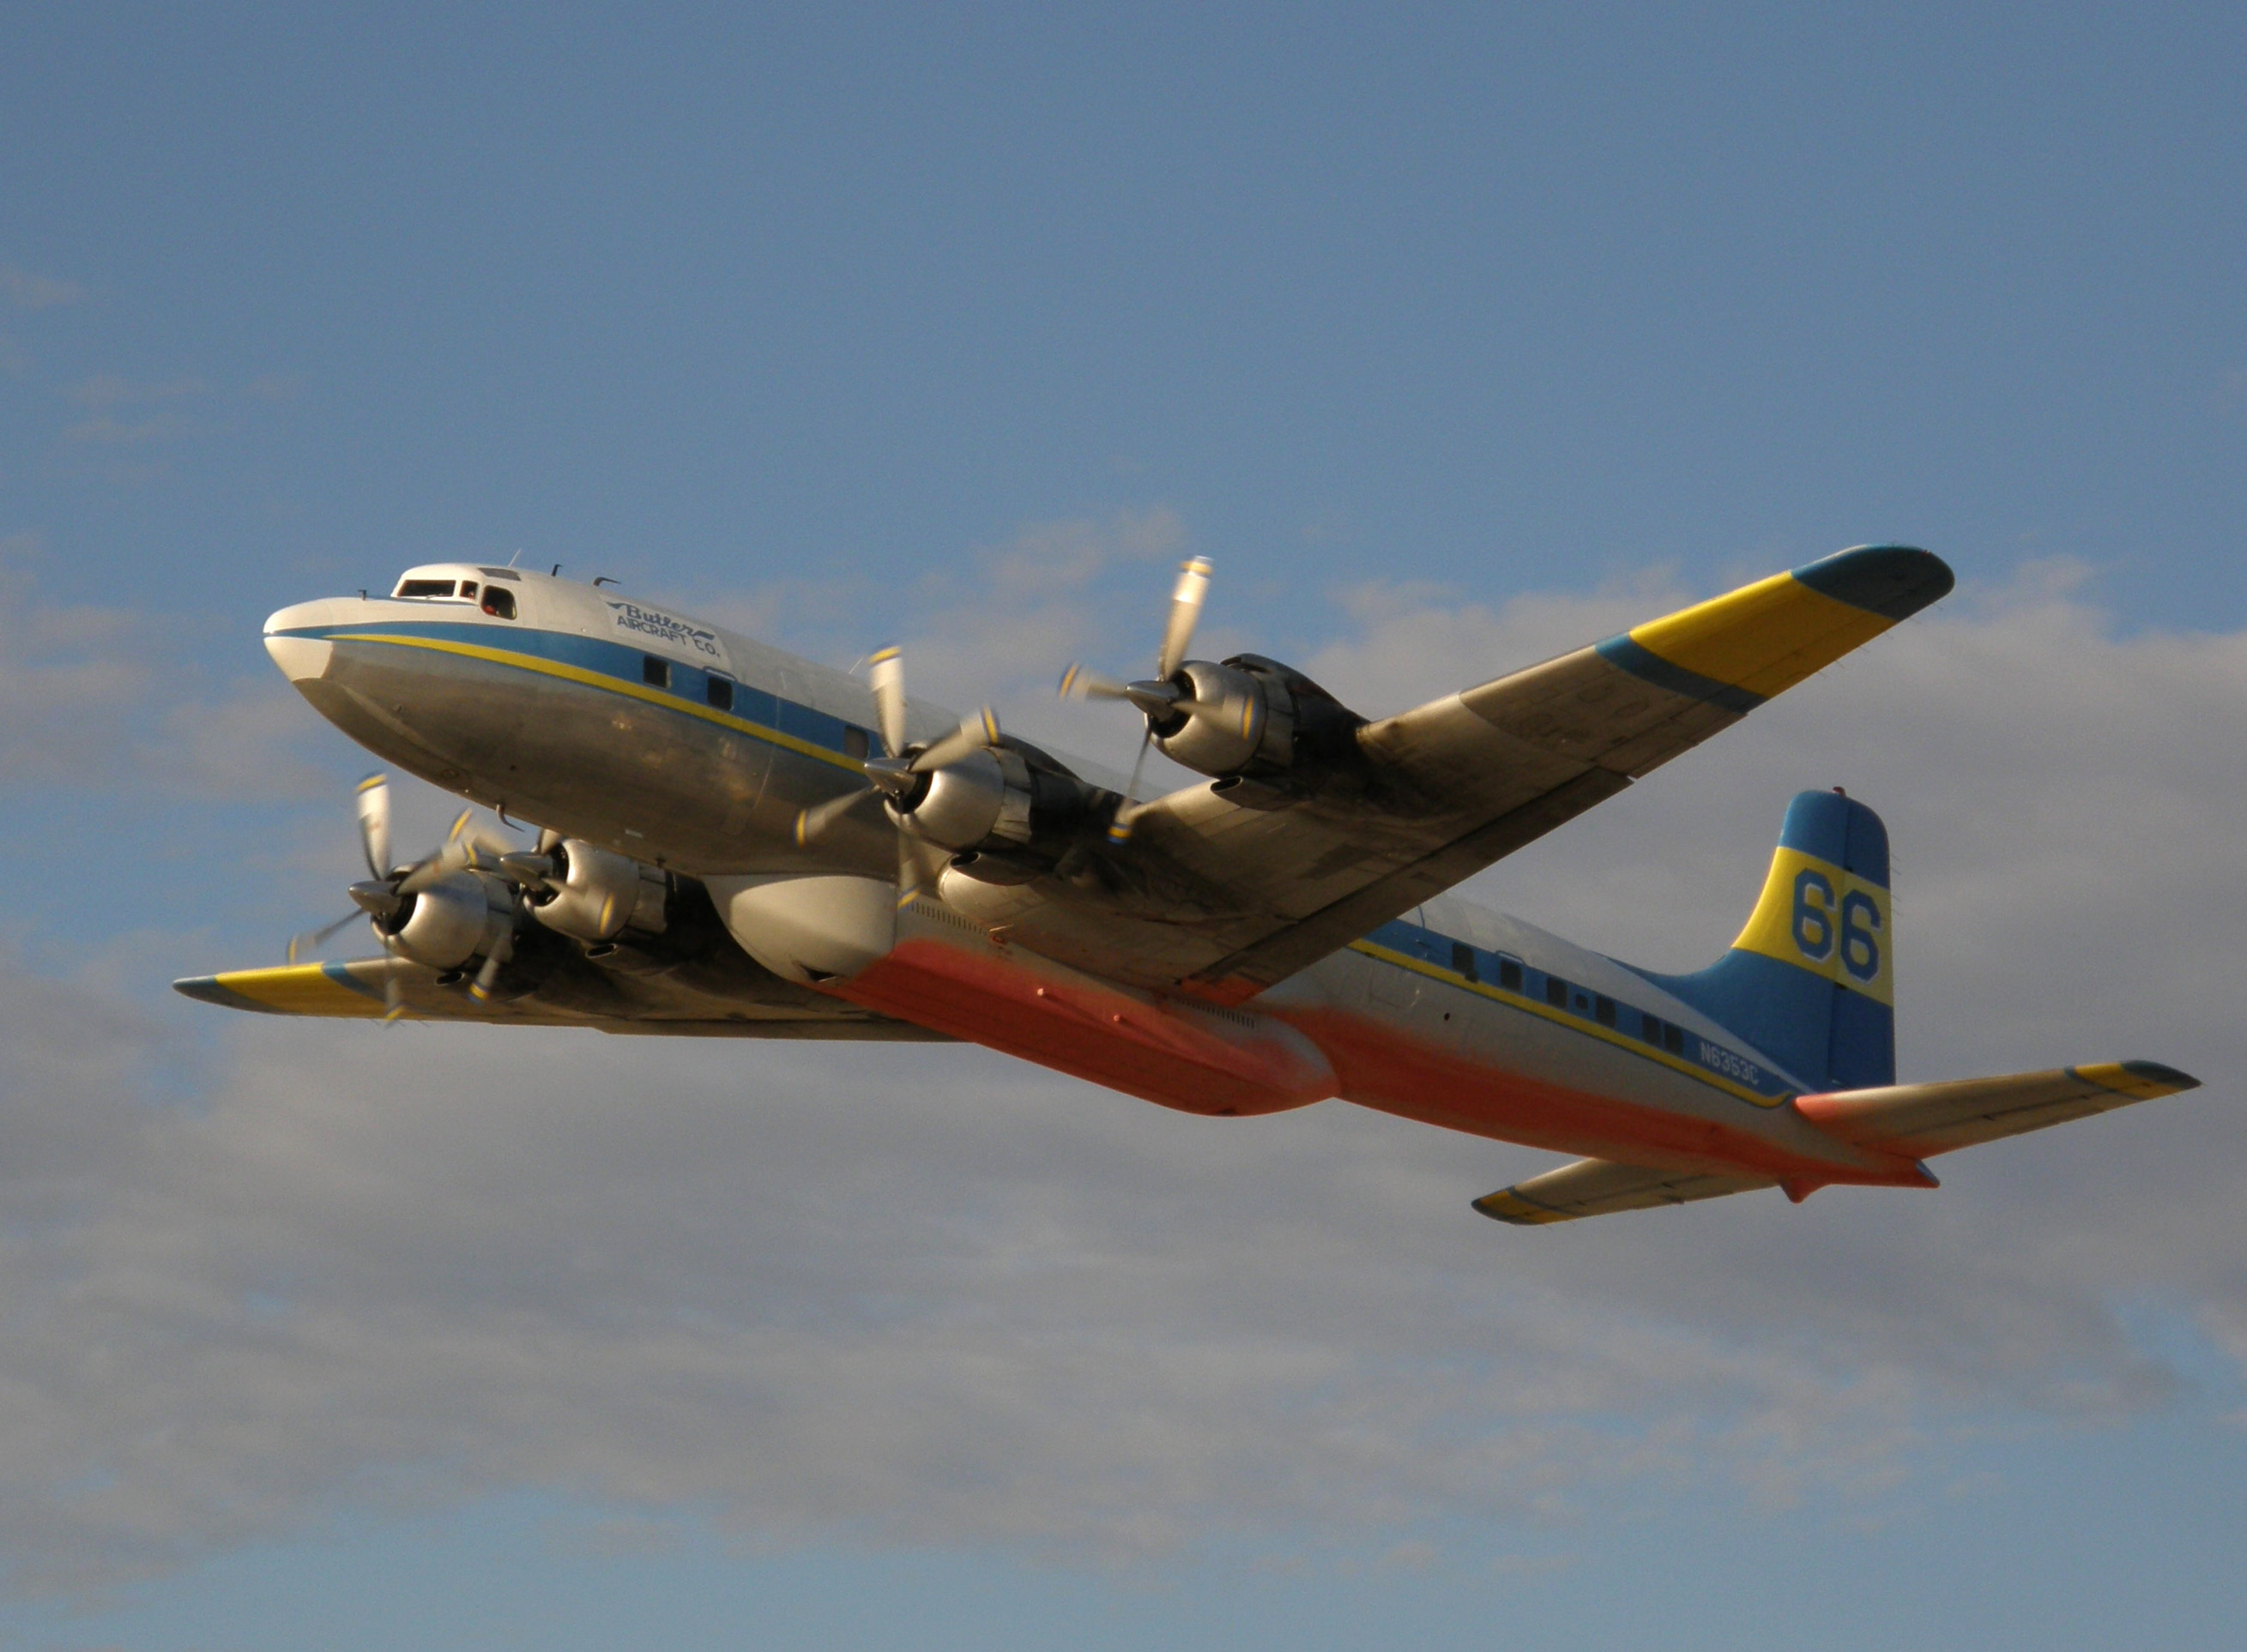

In [1]:
from IPython.display import Image
Image("DouglasDC-7.jpg")

Now that we have a more phyical idea of what we;re analyzing, let's get to work! First things first though, let's import all the libraries we'll need to do all the math needed for analysis and to plot our results.

In [2]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot

%matplotlib inline

### Classes Classes Classes!
The next thing we'll do is define some classes to use in our code.

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculated the center, length, and angle 
        (with the x-axis) of the panel.
        Initializes the strength of the source-sheet, the tangential velocity,
        and the pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2        # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2) # length of panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
            
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
            
        self.sigma = 0     # source strength
        self.vt = 0        # tangential velocity
        self.cp = 0        # pressure coefficient

In [4]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attach in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = math.radians(alpha)

### Functions Functions Functions!
This is our last step before the real fun begins. Time to define all of our functions! The analysis of the airfoils will be done using the vortex-source panel method so the functions defined below are the ones that will define the panels, determine the source and vortex contribution for each panel, satisfy the Kutta condition, and compute the pressure coefficients and velocity fields.

In [5]:
def define_panels(x, y):
    """
    Creates panels form discretized geometry.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    
    Returns
    -------
    panels: 1D numpy array of Panel objects
        The list of panels.
    """
    N = len(x)-1
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
        
    return panels

In [6]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float 
        x_coordinate of the target point.
    y: float
        y_coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                   +(y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [7]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i!=j:
                A[i,j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                               panel_j, numpy.cos(panel_i.beta),
                                               numpy.sin(panel_i.beta))
    return A

In [8]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
        
    Returns
    -------
    A: 2D numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i!=j:
                A[i,j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc,
                                               panel_j, numpy.sin(panel_i.beta),
                                               -numpy.cos(panel_i.beta))
    return A

In [9]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    
    # matrix of source contribution on the tangential velocity 
    # is the same as the
    # matric of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    
    # matrix of vortex contribution on tangential velocity
    # is the same as the
    # matrix of source contribution on normal velocity
    b[-1] = -numpy.sum(A_source[0, :] + A_source[-1, :])
    
    return b

In [10]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from souce and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A: 2D numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    
    # source contribution matrix
    A[:-1, :-1] = A_source
    
    # vortex contribution array 
    # fill the last column of all rows but the last of A
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    
    # Kutta condition array
    # fill all the columns in the last row of A
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [11]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf*numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*(numpy.sin(freestream.alpha-panels[0].beta)
                              +numpy.sin(freestream.alpha-panels[-1].beta))
    return b

In [12]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array pf Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circular density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocuty.
    """
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    
    # matrix of source contribution on tangential velocity
    # is the same as the
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    
    # matrix of vortex contribution on tangential velocity
    # is the opposite of the
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta for panel in panels])
    
    strenghs = numpy.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [13]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [14]:
def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field.
    
    Parameters
    ----------
    panels: 1D array of panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
        
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    Nx, Ny = X.shape
    u, v = numpy.empty((Nx, Ny), dtype=float), numpy.empty((Nx, Ny), dtype=float)
    
    for i in range(Nx):
        for j in range(Ny):
            u[i,j] = freestream.u_inf*math.cos(freestream.alpha)\
                     + 0.5/math.pi*sum([panel.sigma*integral(X[i,j], Y[i,j], panel, 1, 0) for panel in panels])
            v[i,j] = freestream.u_inf*math.sin(freestream.alpha)\
                     + 0.5/math.pi*sum([panel.sigma*integral(X[i,j], Y[i,j], panel, 0, 1) for panel in panels])
    
    return u, v

### Load Load Load!
Now that that's over with, let's get to the good stuff! First we'll take a look at three airfoil geometries we'll be working with.

In [15]:
d_foilx, d_foily = numpy.loadtxt("Douglas_DC-7.txt", dtype=float, unpack=True)
l_foilx, l_foily = numpy.loadtxt("Lockheed_Constellation.txt", dtype=float, unpack=True)
b_foilx, b_foily = numpy.loadtxt("Boeing_707.txt", dtype=float, unpack=True)

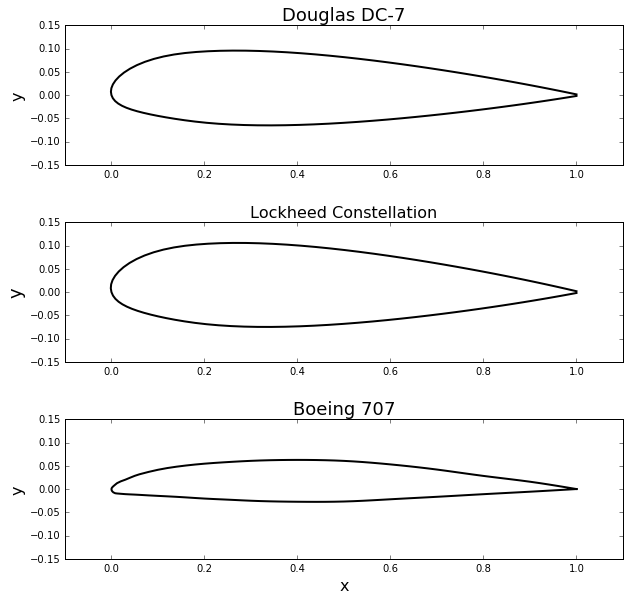

In [16]:
size = 10
pyplot.figure(figsize=(size, size))

pyplot.subplot(311)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.15, 0.15)
pyplot.ylabel('y', fontsize=16)
pyplot.title('Douglas DC-7', fontsize=18)
pyplot.plot(d_foilx, d_foily, color='k', linestyle='-', linewidth=2)

pyplot.subplot(312)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.15, 0.15)
pyplot.ylabel('y', fontsize=18)
pyplot.title('Lockheed Constellation', fontsize=16)
pyplot.plot(l_foilx, l_foily, color='k', linestyle='-', linewidth=2)

pyplot.subplot(313)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.15, 0.15)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.title('Boeing 707', fontsize=18)
pyplot.plot(b_foilx, b_foily, color='k', linestyle='-', linewidth=2);

Notice the similarity between the geometries for the Douglas and Lockheed airfoils and then the departure of that traditional shape in the Boeing airfoil. Does this mean our results for the Boeing 707 will be significantly different? Let's find out! 

We'll start with the Douglas DC-7 airfoil. The first step in our analysis is to create panels from the discretized geometry.

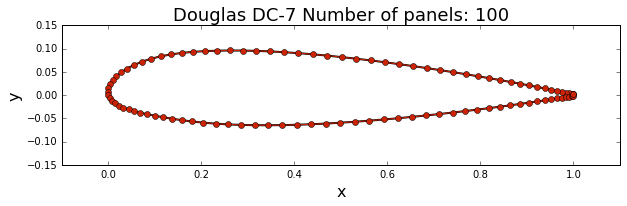

In [17]:
panelsd = define_panels(d_foilx, d_foily)

size = 10
pyplot.figure(figsize=(size, size))
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.15, 0.15)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.title('Douglas DC-7 Number of panels: {}'.format(panelsd.size), fontsize=18)
pyplot.plot(d_foilx, d_foily, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panelsd], panelsd[0].xa),
            numpy.append([panel.ya for panel in panelsd], panelsd[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');

Next, we'll define our freestream conditions. For the first run we'll be looking at the behaviour of these airfoils at an angle of attack of $0^\circ$.

In [18]:
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

Next we have to determine the source and vortex contributions from each panel on all of the other panels.

In [19]:
A_sourced = source_contribution_normal(panelsd)
B_vortexd = vortex_contribution_normal(panelsd)

Now that we've done that, we can determine the strength of the source on each panel and the strength of the vortex to enforce the Kutta condition. Then we'll have all the information we need to compute our pressure and lift coefficients for the airfoil and then plot our results.

In [20]:
Ad = build_singularity_matrix(A_sourced, B_vortexd)
bd = build_freestream_rhs(panelsd, freestream)

strengths = numpy.linalg.solve(Ad, bd)

for i , panel in enumerate(panelsd):
    panel.sigma = strengths[i]
    
gamma = strengths[-1:]

In [21]:
compute_tangential_velocity(panelsd, freestream, gamma, A_sourced, B_vortexd)
compute_pressure_coefficient(panelsd, freestream)

Ld = 0
for panel in panelsd:
    Ld -= panel.cp*panel.length*math.sin(panel.beta)

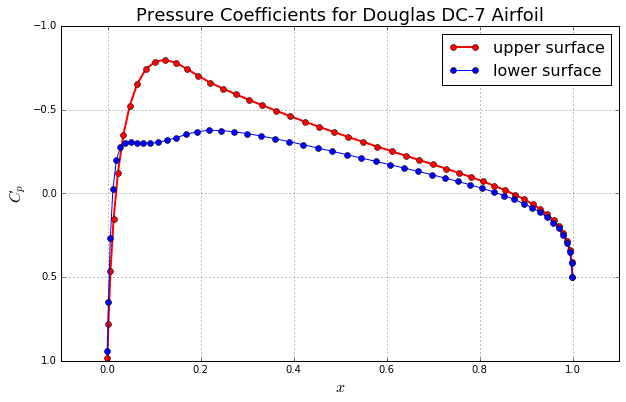

In [22]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panelsd if panel.loc=='upper'],
            [panel.cp for panel in panelsd if panel.loc=='upper'],
           label='upper surface', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panelsd if panel.loc=='lower'],
            [panel.cp for panel in panelsd if panel.loc=='lower'],
           label='lower surface', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -1.0)
pyplot.title('Pressure Coefficients for Douglas DC-7 Airfoil', fontsize=18);

Not too bad right? Now let's repeat the process for our other two airfoils.

In [23]:
# Lockheed Constellation
panelsl= define_panels(l_foilx, l_foily)
A_sourcel = source_contribution_normal(panelsl)
B_vortexl = vortex_contribution_normal(panelsl)

Al = build_singularity_matrix(A_sourcel, B_vortexl)
bl = build_freestream_rhs(panelsl, freestream)

strengths = numpy.linalg.solve(Al, bl)
for i , panel in enumerate(panelsl):
    panel.sigma = strengths[i]    
gamma = strengths[-1:]

compute_tangential_velocity(panelsl, freestream, gamma, A_sourcel, B_vortexl)
compute_pressure_coefficient(panelsl, freestream)

Ll = 0
for panel in panelsl:
    Ll -= panel.cp*panel.length*math.sin(panel.beta)

In [24]:
# Boeing 707
panelsb= define_panels(b_foilx, b_foily)
A_sourceb = source_contribution_normal(panelsb)
B_vortexb = vortex_contribution_normal(panelsb)

Ab = build_singularity_matrix(A_sourceb, B_vortexb)
bb = build_freestream_rhs(panelsb, freestream)

strengths = numpy.linalg.solve(Ab, bb)
for i , panel in enumerate(panelsb):
    panel.sigma = strengths[i]    
gamma = strengths[-1:]

compute_tangential_velocity(panelsb, freestream, gamma, A_sourceb, B_vortexb)
compute_pressure_coefficient(panelsb, freestream)

Lb = 0
for panel in panelsb:
    Lb -= panel.cp*panel.length*math.sin(panel.beta)

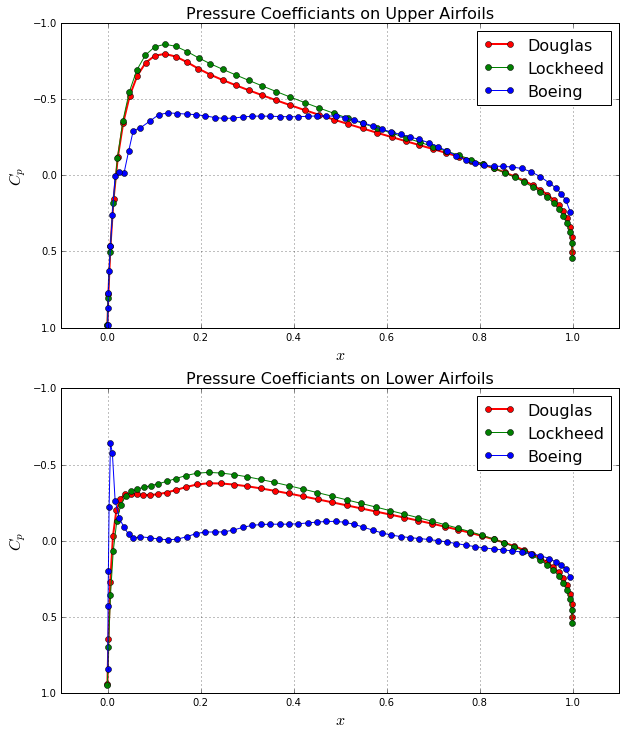

In [25]:
# plot results
pyplot.figure(figsize=(10, 12))

pyplot.subplot(211)
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panelsd if panel.loc=='upper'],
            [panel.cp for panel in panelsd if panel.loc=='upper'],
           label='Douglas', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panelsl if panel.loc=='upper'],
            [panel.cp for panel in panelsl if panel.loc=='upper'],
           label='Lockheed', color='g', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panelsb if panel.loc=='upper'],
            [panel.cp for panel in panelsb if panel.loc=='upper'],
           label='Boeing', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -1.0)
pyplot.title('Pressure Coefficiants on Upper Airfoils', fontsize=16)

pyplot.subplot(212)
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panelsd if panel.loc=='lower'],
            [panel.cp for panel in panelsd if panel.loc=='lower'],
           label='Douglas', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panelsl if panel.loc=='lower'],
            [panel.cp for panel in panelsl if panel.loc=='lower'],
           label='Lockheed', color='g', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panelsb if panel.loc=='lower'],
            [panel.cp for panel in panelsb if panel.loc=='lower'],
           label='Boeing', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -1.0)
pyplot.title('Pressure Coefficiants on Lower Airfoils', fontsize=16);

Between the Lockheed Constellation the Douglas DC-7, the pressure coefficients follow the same general trend but the slightly thicker geometry of the Constellation airfoil results in a slightly higher coefficient of pressure. Additionally, it turns out that the Boeing airfoil geometry does give us pretty different results for the pressure coefficients. But what does that mean? Is it better or worse? Next, we'll compute the pressure field around the airfoils and see if we can get any insight from that. 

In [26]:
N = 51
x_start, x_end = -0.5, 1.5
y_start, y_end = -0.5, 0.5
x = numpy.linspace(x_start,x_end,N)
y = numpy.linspace(y_start,y_end,N)
X, Y = numpy.meshgrid(x,y)

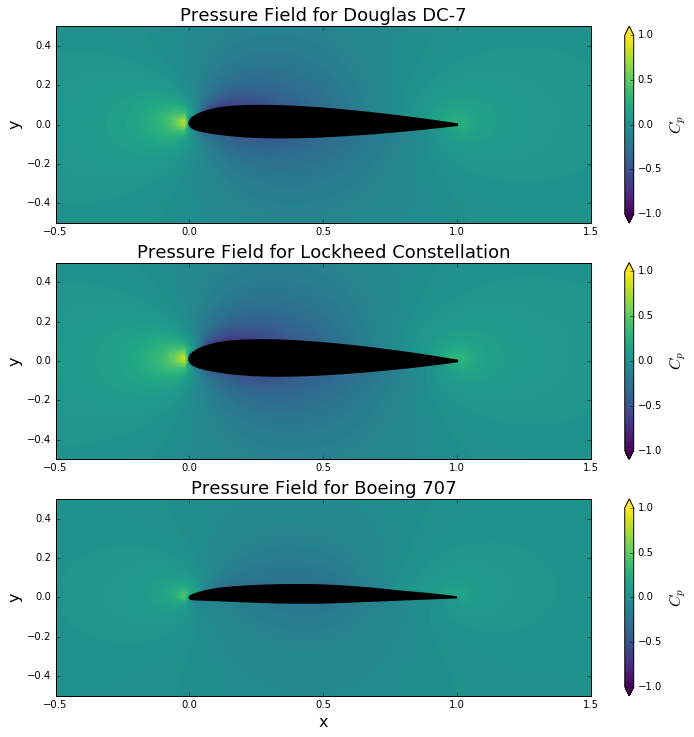

In [27]:
# compute pressure fields
ud, vd = get_velocity_field(panelsd, freestream, X, Y)
cpd = 1.0 - (ud**2+vd**2)/freestream.u_inf**2

ul, vl = get_velocity_field(panelsl, freestream, X, Y)
cpl = 1.0 - (ul**2+vl**2)/freestream.u_inf**2

ub, vb = get_velocity_field(panelsb, freestream, X, Y)
cpb = 1.0 - (ub**2+vb**2)/freestream.u_inf**2

# plot results
size=12
pyplot.figure(figsize=(size, size))

pyplot.subplot(311)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cpd, levels=numpy.linspace(-1.0, 1.0, 100), extend='both', cmap='viridis')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-1.0, -0.5, 0.0, 0.5, 1.0])
pyplot.fill([panel.xc for panel in panelsd], 
         [panel.yc for panel in panelsd], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-0.5, 0.5)
pyplot.title('Pressure Field for Douglas DC-7', fontsize=18)

pyplot.subplot(312)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cpl, levels=numpy.linspace(-1.0, 1.0, 100), extend='both', cmap='viridis')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-1.0, -0.5, 0.0, 0.5, 1.0])
pyplot.fill([panel.xc for panel in panelsl], 
         [panel.yc for panel in panelsl], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-0.5, 0.5)
pyplot.title('Pressure Field for Lockheed Constellation', fontsize=18)

pyplot.subplot(313)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cpb, levels=numpy.linspace(-1.0, 1.0, 100), extend='both', cmap='viridis')
cbar = pyplot.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-1.0, -0.5, 0.0, 0.5, 1.0])
pyplot.fill([panel.xc for panel in panelsb], 
         [panel.yc for panel in panelsb], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-0.5, 0.5)
pyplot.title('Pressure Field for Boeing 707', fontsize=18);

What we really want to look at is the coefficient of lift for each of these airfoils but before we do that we want to be able to compare them lift coefficients at different angles of attack. 

Our singularity matrices for each airfoil remain the same so all we have to do differently from before is change our freestream conditions. 

In [28]:
u_inf = 1.0
alpha = 5.0
freestream = Freestream(u_inf, alpha)

In [29]:
# Douglas DC-7
bd = build_freestream_rhs(panelsd, freestream)

strengths = numpy.linalg.solve(Ad, bd)
for i , panel in enumerate(panelsd):
    panel.sigma = strengths[i]    
gamma = strengths[-1:]

compute_tangential_velocity(panelsd, freestream, gamma, A_sourced, B_vortexd)
compute_pressure_coefficient(panelsd, freestream)
Ld5 = 0
for panel in panelsd:
    Ld5 -= panel.cp*panel.length*math.sin(panel.beta)

# Lockheed Constellation
bl = build_freestream_rhs(panelsl, freestream)

strengths = numpy.linalg.solve(Al, bl)
for i , panel in enumerate(panelsl):
    panel.sigma = strengths[i]    
gamma = strengths[-1:]

compute_tangential_velocity(panelsl, freestream, gamma, A_sourcel, B_vortexl)
compute_pressure_coefficient(panelsl, freestream)
Ll5 = 0
for panel in panelsl:
    Ll5 -= panel.cp*panel.length*math.sin(panel.beta)

# Boeing 707
bb = build_freestream_rhs(panelsb, freestream)

strengths = numpy.linalg.solve(Ab, bb)
for i , panel in enumerate(panelsb):
    panel.sigma = strengths[i]    
gamma = strengths[-1:]

compute_tangential_velocity(panelsb, freestream, gamma, A_sourceb, B_vortexb)
compute_pressure_coefficient(panelsb, freestream)
Lb5 = 0
for panel in panelsb:
    Lb5 -= panel.cp*panel.length*math.sin(panel.beta)

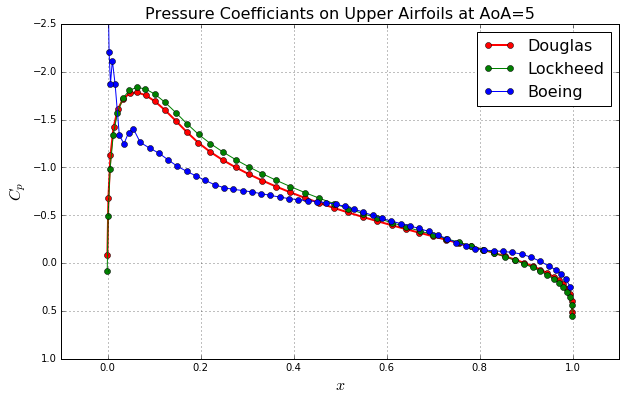

In [30]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panelsd if panel.loc=='upper'],
            [panel.cp for panel in panelsd if panel.loc=='upper'],
           label='Douglas', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panelsl if panel.loc=='upper'],
            [panel.cp for panel in panelsl if panel.loc=='upper'],
           label='Lockheed', color='g', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panelsb if panel.loc=='upper'],
            [panel.cp for panel in panelsb if panel.loc=='upper'],
           label='Boeing', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -2.5)
pyplot.title('Pressure Coefficiants on Upper Airfoils at AoA=5', fontsize=16);

That's quite an increase in the pressure coefficients for just a $5^\circ$ difference in the angle of attack, about a 50% increase. Let's do it again for AoA=$10^\circ$ and compare the lift.

In [31]:
u_inf = 1.0
alpha = 10.0
freestream = Freestream(u_inf, alpha)

In [32]:
# Douglas DC-7
bd = build_freestream_rhs(panelsd, freestream)

strengths = numpy.linalg.solve(Ad, bd)
for i , panel in enumerate(panelsd):
    panel.sigma = strengths[i]    
gamma = strengths[-1:]

compute_tangential_velocity(panelsd, freestream, gamma, A_sourced, B_vortexd)
compute_pressure_coefficient(panelsd, freestream)
Ld10 = 0
for panel in panelsd:
    Ld10 -= panel.cp*panel.length*math.sin(panel.beta)

# Lockheed Constellation
bl = build_freestream_rhs(panelsl, freestream)

strengths = numpy.linalg.solve(Al, bl)
for i , panel in enumerate(panelsl):
    panel.sigma = strengths[i]    
gamma = strengths[-1:]

compute_tangential_velocity(panelsl, freestream, gamma, A_sourcel, B_vortexl)
compute_pressure_coefficient(panelsl, freestream)
Ll10 = 0
for panel in panelsl:
    Ll10 -= panel.cp*panel.length*math.sin(panel.beta)

# Boeing 707
bb = build_freestream_rhs(panelsb, freestream)

strengths = numpy.linalg.solve(Ab, bb)
for i , panel in enumerate(panelsb):
    panel.sigma = strengths[i]    
gamma = strengths[-1:]

compute_tangential_velocity(panelsb, freestream, gamma, A_sourceb, B_vortexb)
compute_pressure_coefficient(panelsb, freestream)
Lb10 = 0
for panel in panelsb:
    Lb10 -= panel.cp*panel.length*math.sin(panel.beta)

In [33]:
print('Angle of Attack\t\t Douglas DC-7\t\t Lockheed Constellation\t\t Boeing 707')
print('0 \t\t\t%.3f\t\t\t%.3f\t\t\t\t%.3f' % (Ld, Ll, Lb))
print('5 \t\t\t%.3f\t\t\t%.3f\t\t\t\t%.3f' % (Ld5, Ll5, Lb5))
print('10 \t\t\t%.3f\t\t\t%.3f\t\t\t\t%.3f' % (Ld10, Ll10, Lb10))

Angle of Attack		 Douglas DC-7		 Lockheed Constellation		 Boeing 707
0 			0.144			0.148				0.209
5 			0.756			0.768				0.794
10 			1.347			1.366				1.358


In the table above, we see the lift coefficients for each airfoil at three different angles of attack. But can we tell which is the best airfoil from this information? Is there even a best one? The Boeing 707 airfoil generates the greatest lift at a $0^\circ$ angle of attack but the Lockheed Constellation airfoil has the greatest increase in lift as the angle is increased. Even still, the lift coefficients are pretty close in value so does it even make a difference?

Truth is, there are so many factors to consider when choosing an airfoil for an aircraft, not just lift and pressure coeffecients. One huge difference between these three aircraft is that the Boeing 707 uses jet propulsion while the Douglas and Lockheed are both propeller aircraft. This would change the requirements for the airfoil best suited to the plane. While we can'e say from this information which aircraft was best, it's certainly an interesting comparison of three very successful US competitors!